# Lasso analysis of housing sale price

##  learning objectives
### (1) How to create training and testing data sets?
### (2) How to fit Lasso with a fixed tuning parameter?
### (3) How to use cross-validation to select the optimal tuning parameter
### (4) How to evaluate the MSE on the testing data set?


In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns
%matplotlib inline
from sklearn.linear_model import (LinearRegression, Ridge, Lasso, lasso_path)

In [109]:
hs = pd.read_csv("https://raw.githubusercontent.com/wangx346/MAS651/main/housesale2.csv")

In [84]:
hs.info()
# Remove all the observations with missing values
hs = hs.dropna()
hs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7095 entries, 0 to 7094
Data columns (total 21 columns):
id               7095 non-null int64
date             7095 non-null object
price            7095 non-null float64
bedrooms         7095 non-null int64
bathrooms        7095 non-null float64
sqft_living      7095 non-null int64
sqft_lot         7095 non-null int64
floors           7095 non-null float64
waterfront       7095 non-null int64
view             7095 non-null int64
condition        7095 non-null int64
grade            7095 non-null int64
sqft_above       7095 non-null int64
sqft_basement    7095 non-null int64
yr_built         7095 non-null int64
yr_renovated     7095 non-null int64
zipcode          7095 non-null int64
lat              7095 non-null float64
long             7095 non-null float64
sqft_living15    7095 non-null int64
sqft_lot15       7095 non-null int64
dtypes: float64(5), int64(15), object(1)
memory usage: 1.1+ MB


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [85]:
hs.shape

(7095, 21)

In [110]:
# Dropping a few columns
hs = hs.drop(['id', 'date', 'view', 'waterfront'],axis=1)

C:\Users\lxw19\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\lxw19\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


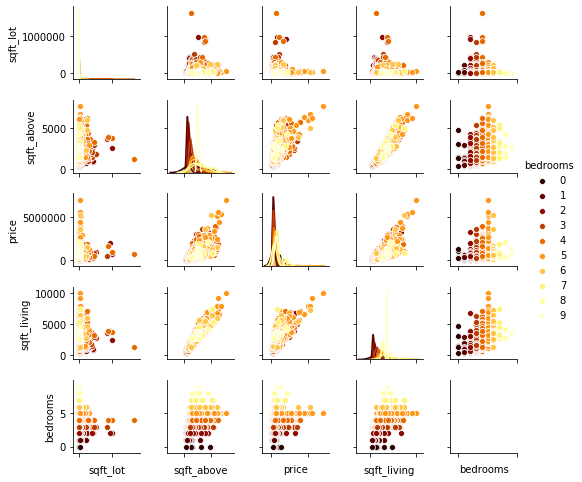

In [87]:
p = sns.pairplot(hs[['sqft_lot','sqft_above','price','sqft_living','bedrooms']], hue='bedrooms', palette='afmhot',height=1.4)
p.set(xticklabels=[])

In [88]:
hs.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,180000.0,2,1.00,770,10000,1.0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


### The LASSO (Least Absolute Shrinkage and Selection Operator) is a regression method that involves penalizing the absolute size of the regression coefficients.

By penalizing or constraining the sum of the absolute values of the estimates you make some of your coefficients zero. The larger the penalty applied, the further estimates are shrunk towards zero. This is convenient when we want some automatic feature/variable selection, or when dealing with highly correlated predictors, where standard regression will usually have regression coefficients that are too large.

In [111]:

# Load the dataset into Pandas Dataframe
hs_pd = pd.DataFrame(hs)
hs_pd.columns = hs.columns
print(hs_pd.head())

# input
X = hs_pd.iloc[:, :-1]
 
#output
Y = hs_pd.iloc[:, -1]
Y

      price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  condition  \
0  221900.0         3       1.00         1180      5650     1.0          3   
1  538000.0         3       2.25         2570      7242     2.0          3   
2  180000.0         2       1.00          770     10000     1.0          3   
3  604000.0         4       3.00         1960      5000     1.0          5   
4  510000.0         3       2.00         1680      8080     1.0          3   

   grade  sqft_above  sqft_basement  yr_built  yr_renovated  zipcode      lat  \
0      7        1180              0      1955             0    98178  47.5112   
1      7        2170            400      1951          1991    98125  47.7210   
2      6         770              0      1933             0    98028  47.7379   
3      7        1050            910      1965             0    98136  47.5208   
4      8        1680              0      1987             0    98074  47.6168   

      long  sqft_living15  sqft_lot15  
0 -1

0        5650
1        7639
2        8062
3        5000
4        7503
        ...  
7090     1562
7091     3360
7092     9375
7093    87991
7094     8041
Name: sqft_lot15, Length: 7095, dtype: int64

In [108]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(hs_pd.iloc[:, :-1], hs_pd.iloc[:, -1],
    test_size = 0.25)
 
print("Train data shape of X = % s and Y = % s : "%(x_train.shape, y_train.shape))
 
print("Test data shape of X = % s and Y = % s : "%(x_test.shape, y_test.shape))

Train data shape of X = (5321, 16) and Y = (5321,) : 
Test data shape of X = (1774, 16) and Y = (1774,) : 


In [98]:
# Train Lasso model
lasso = Lasso(alpha=0.2, normalize=True)

# Fit the regressor to the data
lasso.fit(x_train, y_train)

lasso_coeff = pd.DataFrame()
lasso_coeff["Columns"] = x_train.columns
lasso_coeff['Coefficient Estimate'] = pd.Series(lasso.coef_)
 
print(lasso_coeff)

          Columns  Coefficient Estimate
0           price             -0.003386
1        bedrooms          -1974.838480
2       bathrooms           -429.145302
3     sqft_living              3.093748
4        sqft_lot              0.376887
5          floors          -3069.951195
6       condition            617.701833
7           grade          -1323.480868
8      sqft_above              1.603723
9   sqft_basement              0.000000
10       yr_built             15.205797
11   yr_renovated              1.811219
12        zipcode              2.242150
13            lat           1788.705014
14           long          21767.721702
15  sqft_living15              2.465153


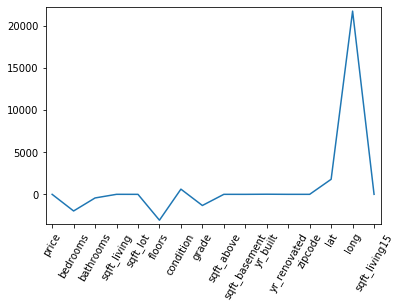

In [102]:
# Plot the coefficients
plt.plot(range(len(lasso_coeff["Columns"])), lasso_coeff['Coefficient Estimate'])
plt.xticks(range(len(lasso_coeff["Columns"])), lasso_coeff["Columns"], rotation=60) 
plt.margins(0.02)
plt.show()

In [103]:
y_pred1 = lasso.predict(x_test)
 
# Calculate Mean Squared Error
mean_squared_error = np.mean((y_pred1 - y_test)**2)
print("Mean squared error on test set", mean_squared_error)

Mean squared error on test set 361774398.1638711


##  How to choose the tuning parameter?

In [134]:
from sklearn.metrics import mean_squared_error

## Lasso with 10-fold cross-validation

lassocv = LassoCV(alphas=None, cv=10, max_iter=100000, normalize=True)
lassocv.fit(x_train, y_train)
## print the best choice of the tunin parameter
print("Alpha=", lassocv.alpha_)


Alpha= 0.6009790391455814


In [138]:
## Use the chosen tuning paramter for the final model
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(x_train, y_train)
mean_squared_error(y_test, lasso.predict(x_test))

print("best model coefficients:")
pd.Series(lasso.coef_, index=X.columns)

best model coefficients:


price               -0.003884
bedrooms         -1972.121030
bathrooms         -608.565901
sqft_living          2.738631
sqft_lot             0.343297
floors           -2247.633582
condition          642.739288
grade             -892.829450
sqft_above           1.998055
sqft_basement        0.000000
yr_built             0.000000
yr_renovated         2.002546
zipcode              2.171825
lat               -231.672750
long             22036.312827
sqft_living15        2.990712
dtype: float64

## Plot Lasso path (optional)

In [125]:
alphas = np.linspace(0.01,500,100)
alphas

array([1.00000000e-02, 5.06040404e+00, 1.01108081e+01, 1.51612121e+01,
       2.02116162e+01, 2.52620202e+01, 3.03124242e+01, 3.53628283e+01,
       4.04132323e+01, 4.54636364e+01, 5.05140404e+01, 5.55644444e+01,
       6.06148485e+01, 6.56652525e+01, 7.07156566e+01, 7.57660606e+01,
       8.08164646e+01, 8.58668687e+01, 9.09172727e+01, 9.59676768e+01,
       1.01018081e+02, 1.06068485e+02, 1.11118889e+02, 1.16169293e+02,
       1.21219697e+02, 1.26270101e+02, 1.31320505e+02, 1.36370909e+02,
       1.41421313e+02, 1.46471717e+02, 1.51522121e+02, 1.56572525e+02,
       1.61622929e+02, 1.66673333e+02, 1.71723737e+02, 1.76774141e+02,
       1.81824545e+02, 1.86874949e+02, 1.91925354e+02, 1.96975758e+02,
       2.02026162e+02, 2.07076566e+02, 2.12126970e+02, 2.17177374e+02,
       2.22227778e+02, 2.27278182e+02, 2.32328586e+02, 2.37378990e+02,
       2.42429394e+02, 2.47479798e+02, 2.52530202e+02, 2.57580606e+02,
       2.62631010e+02, 2.67681414e+02, 2.72731818e+02, 2.77782222e+02,
      

In [126]:
lasso = Lasso(max_iter=10000, normalize=True)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(x_train, y_train)
    coefs.append(lasso.coef_)
    
np.shape(coefs)

(100, 16)

In [ ]:
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Lasso coefficients')
plt.title('Lasso coefficients as a function of alpha')

##### Remember that if alpha = 0, then the lasso gives the least squares fit, and when alpha becomes very large, the lasso gives the null model in which all coefficient estimates equal zero. Moving from left to right in our plot, we observe that at first the lasso models contains many predictors with high magnitudes of coefficient estimates. With increasing alpha, the coefficient estimates approximate towards zero.